In [1]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

In [2]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
Base = automap_base()
Base.prepare(engine, reflect=True)

In [5]:
Base.classes.keys()

['measurement', 'station']

In [6]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
session = Session(engine)
conn = engine.connect()

In [8]:
date_list = []
prcp_list = []
temp_list = []
for instance in session.query(Measurement):

    date_list.append(instance.date)
    prcp_list.append(instance.prcp)
    temp_list.append(instance.tobs)

In [9]:
max_date = pd.read_sql("select date from measurement",conn)
max_date = max_date.values.tolist()
max_date = max(max_date)
max_date = ''.join(max_date)

year,month,day = max_date.split('-')
year_from_max = datetime(int(year),int(month),int(day)) - timedelta(days=365)



year_data = pd.read_sql(f"select * from measurement where date >= '{year_from_max}'",conn)


year_data = year_data[["date","prcp"]]
year_data = year_data.set_index("date")


year_data = year_data.sort_values("date")


/Users/horacelin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


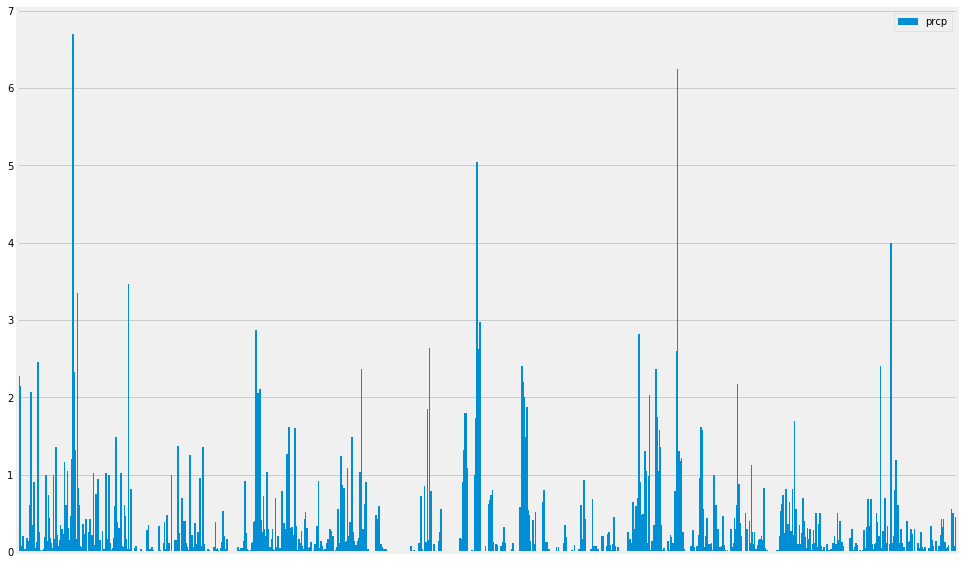

In [10]:
year_data.plot(kind="bar", figsize=(15,10), width = 4)


plt.xticks(rotation=90)
x_axis = plt.axes().axes.get_xaxis()
x_axis.set_visible(False)
plt.xlabel("date")
plt.savefig("precipitationgraph.png")
plt.show()

In [11]:
year_data.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
data_all = pd.read_sql("select * from measurement", conn)
unique = data_all.nunique()
unique = unique.to_dict()
unique['station']

9

In [13]:
most_active_station = data_all.groupby("station").count()
most_active_station_dict = most_active_station["id"].sort_values(ascending = False)
most_active_station["id"].sort_values(ascending = False)
most_active_station_dict = pd.DataFrame(most_active_station_dict)
most_active_station_dict = most_active_station_dict.to_dict()
most_active_station_dict

{'id': {'USC00519281': 2772,
  'USC00519397': 2724,
  'USC00513117': 2709,
  'USC00519523': 2669,
  'USC00516128': 2612,
  'USC00514830': 2202,
  'USC00511918': 1979,
  'USC00517948': 1372,
  'USC00518838': 511}}

In [14]:
active_stn_1 = pd.read_sql("select * from measurement where station = 'USC00519281'",conn)
active_stn_1 = active_stn_1[["tobs"]]
active_stn_1_max = active_stn_1.max().tolist()
active_stn_1_min = active_stn_1.min().tolist()
active_stn_1_avg = active_stn_1.mean().tolist()

to_list = (active_stn_1_min,active_stn_1_max,active_stn_1_avg)
to_list

([54.0], [85.0], [71.66378066378067])

In [18]:
def calc_temps(start_date, end_date):
    return_value = session.query(func.min(Measurement.tobs),func.avg(Measurement.tobs),func.max(Measurement.tobs)).\
    filter(Measurement.date >=start_date).filter(Measurement.date <=end_date).all()
    return return_value
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
print(max_date)
max_date = str(max_date)
year_from_max = year_from_max.date()
print(year_from_max)
min_avg_max = calc_temps(year_from_max,max_date)
print(min_avg_max)

2017-08-23
2016-08-23
[(58.0, 74.59058295964125, 87.0)]


   Trip Avg Temp
0      74.590583


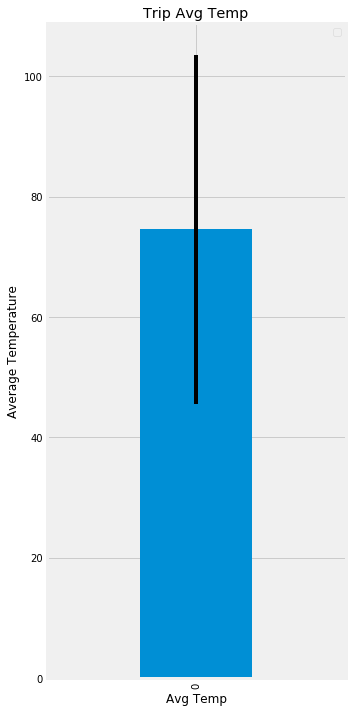

In [20]:
min_avg_max = min_avg_max[0]
TMIN = min_avg_max[0]
TAVG = min_avg_max[1]
TMAX = min_avg_max[2]

# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tavg_frame = pd.DataFrame({"Trip Avg Temp":[TAVG]})
print(tavg_frame)
tavg_frame.plot(kind="bar",width=.3,yerr=(TMAX-TMIN),figsize=(5,10))

# Plot the results from your previous query as a bar chart. 
plt.title("Trip Avg Temp")
plt.legend('')
plt.xlabel("Avg Temp")

# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
plt.ylabel("Average Temperature")
plt.tight_layout()
plt.savefig("BarChart.jpg")
plt.show()

In [21]:
start_date = '2012-02-28'
end_date = '2012-03-05'

measurement_table = pd.read_sql(f"select * from measurement where date between '{start_date}' and '{end_date}'", conn)
station_table = pd.read_sql('select * from station', conn)

# rainfall_per_station
measurement_table = measurement_table[["station","prcp"]]
station_table = station_table[["station","name","latitude","longitude","elevation"]]
measurement_table_grouped = measurement_table.groupby("station").sum()
measurement_table_grouped = measurement_table_grouped.sort_values(by="prcp", ascending=False)

# print(measurement_table_grouped.head())
# print(station_table.head())
measurement_table_grouped

station_table
measurement_station_merged = measurement_table_grouped.merge(station_table, how='inner',on="station")
measurement_station_merged = measurement_station_merged[["station","name","latitude","longitude","elevation","prcp"]]
measurement_station_merged_dict = measurement_station_merged.to_dict(orient='records')
measurement_station_merged_dict

[{'station': 'USC00519281',
  'name': 'WAIHEE 837.5, HI US',
  'latitude': 21.45167,
  'longitude': -157.84888999999998,
  'elevation': 32.9,
  'prcp': 11.08},
 {'station': 'USC00516128',
  'name': 'MANOA LYON ARBO 785.2, HI US',
  'latitude': 21.3331,
  'longitude': -157.8025,
  'elevation': 152.4,
  'prcp': 10.32},
 {'station': 'USC00513117',
  'name': 'KANEOHE 838.1, HI US',
  'latitude': 21.4234,
  'longitude': -157.8015,
  'elevation': 14.6,
  'prcp': 5.79},
 {'station': 'USC00518838',
  'name': 'UPPER WAHIAWA 874.3, HI US',
  'latitude': 21.4992,
  'longitude': -158.0111,
  'elevation': 306.6,
  'prcp': 3.8400000000000003},
 {'station': 'USC00519523',
  'name': 'WAIMANALO EXPERIMENTAL FARM, HI US',
  'latitude': 21.33556,
  'longitude': -157.71139,
  'elevation': 19.5,
  'prcp': 2.92},
 {'station': 'USC00519397',
  'name': 'WAIKIKI 717.2, HI US',
  'latitude': 21.2716,
  'longitude': -157.8168,
  'elevation': 3.0,
  'prcp': 1.1800000000000002},
 {'station': 'USC00511918',
  'name